## Prep

In [1]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=208988 sha256=2b06054604a14013e2ac3355a1879856aef2a7f5d892b7cfa203b0f3a1ec6719
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [2]:
import os
import joblib
import cv2
import time
import argparse
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import pandas as pd
from scipy.signal import savgol_filter
from hampel import hampel
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Computer Vision section

In [4]:
class DWConvblock(nn.Module):
    def __init__(self, input_channels, output_channels, size):
        super(DWConvblock, self).__init__()
        self.size = size
        self.input_channels = input_channels
        self.output_channels = output_channels

        self.block =  nn.Sequential(nn.Conv2d(output_channels, output_channels, size, 1, 2, groups = output_channels, bias = False),
                                    nn.BatchNorm2d(output_channels),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(output_channels, output_channels, 1, 1, 0, bias = False),
                                    nn.BatchNorm2d(output_channels),

                                    nn.Conv2d(output_channels, output_channels, size, 1, 2, groups = output_channels, bias = False),
                                    nn.BatchNorm2d(output_channels ),
                                    nn.ReLU(inplace=True),

                                    nn.Conv2d(output_channels, output_channels, 1, 1, 0, bias = False),
                                    nn.BatchNorm2d(output_channels),
                                    )

    def forward(self, x):
        x = self.block(x)
        return x

class LightFPN(nn.Module):
    def __init__(self, input2_depth, input3_depth, out_depth):
        super(LightFPN, self).__init__()

        self.conv1x1_2 = nn.Sequential(nn.Conv2d(input2_depth, out_depth, 1, 1, 0, bias = False),
                                       nn.BatchNorm2d(out_depth),
                                       nn.ReLU(inplace=True)
                                       )

        self.conv1x1_3 = nn.Sequential(nn.Conv2d(input3_depth, out_depth, 1, 1, 0, bias = False),
                                       nn.BatchNorm2d(out_depth),
                                       nn.ReLU(inplace=True)
                                       )

        self.cls_head_2 = DWConvblock(input2_depth, out_depth, 5)
        self.reg_head_2 = DWConvblock(input2_depth, out_depth, 5)

        self.reg_head_3 = DWConvblock(input3_depth, out_depth, 5)
        self.cls_head_3 = DWConvblock(input3_depth, out_depth, 5)

    def forward(self, C2, C3):
        S3 = self.conv1x1_3(C3)
        cls_3 = self.cls_head_3(S3)
        obj_3 = cls_3
        reg_3 = self.reg_head_3(S3)

        P2 = F.interpolate(C3, scale_factor=2)
        P2 = torch.cat((P2, C2),1)
        S2 = self.conv1x1_2(P2)
        cls_2 = self.cls_head_2(S2)
        obj_2 = cls_2
        reg_2 = self.reg_head_2(S2)

        return  cls_2, obj_2, reg_2, cls_3, obj_3, reg_3

class ShuffleV2Block(nn.Module):
    def __init__(self, inp, oup, mid_channels, *, ksize, stride):
        super(ShuffleV2Block, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        self.mid_channels = mid_channels
        self.ksize = ksize
        pad = ksize // 2
        self.pad = pad
        self.inp = inp

        outputs = oup - inp

        branch_main = [
            # pw
            nn.Conv2d(inp, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(mid_channels, mid_channels, ksize, stride, pad, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            # pw-linear
            nn.Conv2d(mid_channels, outputs, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outputs),
            nn.ReLU(inplace=True),
        ]
        self.branch_main = nn.Sequential(*branch_main)

        if stride == 2:
            branch_proj = [
                # dw
                nn.Conv2d(inp, inp, ksize, stride, pad, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                # pw-linear
                nn.Conv2d(inp, inp, 1, 1, 0, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
            ]
            self.branch_proj = nn.Sequential(*branch_proj)
        else:
            self.branch_proj = None

    def forward(self, old_x):
        if self.stride==1:
            x_proj, x = self.channel_shuffle(old_x)
            return torch.cat((x_proj, self.branch_main(x)), 1)
        elif self.stride==2:
            x_proj = old_x
            x = old_x
            return torch.cat((self.branch_proj(x_proj), self.branch_main(x)), 1)

    def channel_shuffle(self, x):
        batchsize, num_channels, height, width = x.data.size()
        assert (num_channels % 4 == 0)
        x = x.reshape(batchsize * num_channels // 2, 2, height * width)
        x = x.permute(1, 0, 2)
        x = x.reshape(2, -1, num_channels // 2, height, width)
        return x[0], x[1]

class ShuffleNetV2(nn.Module):
    def __init__(self, stage_out_channels, load_param):
        super(ShuffleNetV2, self).__init__()

        self.stage_repeats = [4, 8, 4]
        self.stage_out_channels = stage_out_channels

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, input_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(inplace=True),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        stage_names = ["stage2", "stage3", "stage4"]
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage+2]
            stageSeq = []
            for i in range(numrepeat):
                if i == 0:
                    stageSeq.append(ShuffleV2Block(input_channel, output_channel,
                                                mid_channels=output_channel // 2, ksize=3, stride=2))
                else:
                    stageSeq.append(ShuffleV2Block(input_channel // 2, output_channel,
                                                mid_channels=output_channel // 2, ksize=3, stride=1))
                input_channel = output_channel
            setattr(self, stage_names[idxstage], nn.Sequential(*stageSeq))

        if load_param == False:
            self._initialize_weights()
        else:
            print("load param...")

    def forward(self, x):
        x = self.first_conv(x)
        x = self.maxpool(x)
        C1 = self.stage2(x)
        C2 = self.stage3(C1)
        C3 = self.stage4(C2)

        return C2, C3

    def _initialize_weights(self):
        print("initialize_weights...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.load_state_dict(torch.load("./backbone.pth", map_location=device), strict = True)

class Detector(nn.Module):
    def __init__(self, classes, anchor_num, load_param, export_onnx = False):
        super(Detector, self).__init__()
        out_depth = 72
        stage_out_channels = [-1, 24, 48, 96, 192]

        self.export_onnx = export_onnx
        self.backbone = ShuffleNetV2(stage_out_channels, load_param)
        self.fpn = LightFPN(stage_out_channels[-2] + stage_out_channels[-1], stage_out_channels[-1], out_depth)

        self.output_reg_layers = nn.Conv2d(out_depth, 4 * anchor_num, 1, 1, 0, bias=True)
        self.output_obj_layers = nn.Conv2d(out_depth, anchor_num, 1, 1, 0, bias=True)
        self.output_cls_layers = nn.Conv2d(out_depth, classes, 1, 1, 0, bias=True)

    def forward(self, x):
        C2, C3 = self.backbone(x)
        cls_2, obj_2, reg_2, cls_3, obj_3, reg_3 = self.fpn(C2, C3)

        out_reg_2 = self.output_reg_layers(reg_2)
        out_obj_2 = self.output_obj_layers(obj_2)
        out_cls_2 = self.output_cls_layers(cls_2)

        out_reg_3 = self.output_reg_layers(reg_3)
        out_obj_3 = self.output_obj_layers(obj_3)
        out_cls_3 = self.output_cls_layers(cls_3)

        if self.export_onnx:
            out_reg_2 = out_reg_2.sigmoid()
            out_obj_2 = out_obj_2.sigmoid()
            out_cls_2 = F.softmax(out_cls_2, dim = 1)

            out_reg_3 = out_reg_3.sigmoid()
            out_obj_3 = out_obj_3.sigmoid()
            out_cls_3 = F.softmax(out_cls_3, dim = 1)

            print("export onnx ...")
            return torch.cat((out_reg_2, out_obj_2, out_cls_2), 1).permute(0, 2, 3, 1), \
                   torch.cat((out_reg_3, out_obj_3, out_cls_3), 1).permute(0, 2, 3, 1)

        else:
            return out_reg_2, out_obj_2, out_cls_2, out_reg_3, out_obj_3, out_cls_3


In [5]:
def make_grid(h, w, device):
    hv, wv = torch.meshgrid([torch.arange(h), torch.arange(w)])
    return torch.stack((wv, hv), 2).repeat(1,1,3).reshape(h, w, 3, -1).to(device)

def handel_preds(preds, device):
    #加载anchor配置
    # anchors = np.array(cfg["anchors"])
    anchors = np.array([31.67,166.38, 46.77,209.52, 63.65,253.63, 83.14,292.26, 105.64,333.59, 138.17,346.51])
    anchors = torch.from_numpy(anchors.reshape(len(preds) // 3, 3, 2)).to(device)

    output_bboxes = []
    layer_index = [0, 0, 0, 1, 1, 1]

    for i in range(len(preds) // 3):
        bacth_bboxes = []
        reg_preds = preds[i * 3]
        obj_preds = preds[(i * 3) + 1]
        cls_preds = preds[(i * 3) + 2]

        for r, o, c in zip(reg_preds, obj_preds, cls_preds):
            r = r.permute(1, 2, 0)
            r = r.reshape(r.shape[0], r.shape[1], 3, -1)

            o = o.permute(1, 2, 0)
            o = o.reshape(o.shape[0], o.shape[1], 3, -1)

            c = c.permute(1, 2, 0)
            c = c.reshape(c.shape[0],c.shape[1], 1, c.shape[2])
            c = c.repeat(1, 1, 3, 1)

            anchor_boxes = torch.zeros(r.shape[0], r.shape[1], r.shape[2], r.shape[3] + c.shape[3] + 1)

            #计算anchor box的cx, cy
            grid = make_grid(r.shape[0], r.shape[1], device)
            stride = 352 /  r.shape[0]
            anchor_boxes[:, :, :, :2] = ((r[:, :, :, :2].sigmoid() * 2. - 0.5) + grid) * stride

            #计算anchor box的w, h
            anchors_cfg = anchors[i]
            anchor_boxes[:, :, :, 2:4] = (r[:, :, :, 2:4].sigmoid() * 2) ** 2 * anchors_cfg # wh

            #计算obj分数
            anchor_boxes[:, :, :, 4] = o[:, :, :, 0].sigmoid()

            #计算cls分数
            anchor_boxes[:, :, :, 5:] = F.softmax(c[:, :, :, :], dim = 3)

            #torch tensor 转为 numpy array
            anchor_boxes = anchor_boxes.cpu().detach().numpy()
            bacth_bboxes.append(anchor_boxes)

        #n, anchor num, h, w, box => n, (anchor num*h*w), box
        bacth_bboxes = torch.from_numpy(np.array(bacth_bboxes))
        bacth_bboxes = bacth_bboxes.view(bacth_bboxes.shape[0], -1, bacth_bboxes.shape[-1])

        output_bboxes.append(bacth_bboxes)

    #merge
    output = torch.cat(output_bboxes, 1)

    return output

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(prediction, conf_thres=0.3, iou_thres=0.45, classes=None):
    """Performs Non-Maximum Suppression (NMS) on inference results
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """

    nc = prediction.shape[2] - 5  # number of classes

    # Settings
    # (pixels) minimum and maximum box width and height
    max_wh = 4096
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 1.0  # seconds to quit after
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

    t = time.time()
    output = [torch.zeros((0, 6), device="cpu")] * prediction.shape[0]

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[x[..., 4] > conf_thres]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        conf, j = x[:, 5:].max(1, keepdim=True)
        x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = x[i].detach().cpu()

        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

## WiFi Section

In [6]:
class ESP32:
    """Parse ESP32 Wi-Fi Channel State Information (CSI) obtained using ESP32 CSI Toolkit by Hernandez and Bulut.
    ESP32 CSI Toolkit: https://stevenmhernandez.github.io/ESP32-CSI-Tool/
    """

    NULL_SUBCARRIERS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 64, 65, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 382, 383]

    def __init__(self, csi_file):
        self.csi_file = csi_file
        self.__read_file()

    def __read_file(self):
        """Read RAW CSI file (.csv) using Pandas and return a Pandas dataframe
        """
        self.csi_df = pd.read_csv(self.csi_file)

    def seek_file(self):
        """Seek RAW CSI file
        """
        return self.csi_df

    def filter_by_sig_mode(self, sig_mode):
        """Filter CSI data by signal mode
        Args:
            sig_mode (int):
            0 : Non - High Throughput Signals (non-HT)
            1 : HIgh Throughput Signals (HT)
        """
        self.csi_df = self.csi_df.loc[self.csi_df['sig_mode'] == sig_mode]
        return self

    def get_csi(self):
        """Read CSI string as Numpy array

        The CSI data collected by ESP32 contains channel frequency responses (CFR) represented by two signed bytes (imaginary, real) for each sub-carriers index
        The length (bytes) of the CSI sequency depends on the CFR type
        CFR consist of legacy long training field (LLTF), high-throughput LTF (HT-LTF), and space- time block code HT-LTF (STBC-HT-LTF)
        Ref: https://docs.espressif.com/projects/esp-idf/en/latest/esp32/api-guides/wifi.html#wi-fi-channel-state-information

        NOTE: Not all 3 field may not be present (as represented in table and configuration)
        """
        raw_csi_data = self.csi_df['CSI_DATA'].copy()
        csi_data = np.array([np.fromstring(csi_datum.strip('[ ]'), dtype=int, sep = ' ') for csi_datum in raw_csi_data])
        self.csi_data = csi_data
        return self

    # NOTE: Currently does not provide support for all signal subcarrier types
    def remove_null_subcarriers(self):
        """Remove NULL subcarriers from CSI
        """

        # Non-HT Signals (20 Mhz) - non STBC
        if self.csi_data.shape[1] == 128:
            remove_null_subcarriers = self.NULL_SUBCARRIERS[:24]
        # HT Signals (40 Mhz) - non STBC
        elif self.csi_data.shape[1] == 384:
            remove_null_subcarriers = self.NULL_SUBCARRIERS
        else:
            return self

        csi_data_T = self.csi_data.T
        csi_data_T_clean = np.delete(csi_data_T, remove_null_subcarriers, 0)
        csi_data_clean = csi_data_T_clean.T
        self.csi_data = csi_data_clean

        return self

    def get_amplitude_from_csi(self):
        """Calculate the Amplitude (or Magnitude) from CSI
        Ref: https://farside.ph.utexas.edu/teaching/315/Waveshtml/node88.html
        """
        amplitude = np.array([np.sqrt(data[::2]**2 + data[1::2]**2) for data in self.csi_data])
        self.amplitude = amplitude
        return self

    def get_phase_from_csi(self):
        """Calculate the Amplitude (or Magnitude) from CSI
        Ref: https://farside.ph.utexas.edu/teaching/315/Waveshtml/node88.html
        """
        phase = np.array([np.arctan2(data[::2], data[1::2]) for data in self.csi_data])
        self.phase = phase
        return self

In [7]:
def segment_data(data, window_size=200, overlap=50):
    segmented_data = []
    for i in range(0, data.shape[0] - window_size + 1, window_size - overlap):
        window = data[i:i+window_size] if data.ndim == 1 else data[i:i+window_size, :]
        segmented_data.append(window)
    return segmented_data

def extract_amplitude(raw_data):
    csi_array = (
        ESP32(raw_data)
            .get_csi()
            .remove_null_subcarriers()
            .get_amplitude_from_csi()
    )
    amp_df = pd.DataFrame(csi_array.amplitude, index=None)
    return amp_df

def denoise_data(amp_df):
    filtered_df = pd.DataFrame()
    for col in amp_df.columns:
        col_series = amp_df[col]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
        filtered_df[col] = sg_filtered
    return filtered_df

def extract_features(filtered_df_with_rssi):
    """
    Args:
        filtered_df_with_rssi: numpy array containing CSI amplitude data (shape: [packets, subcarriers])

    Returns:
        A dictionary containing the calculated statistics.
    """
    features = {}
    for i in range(filtered_df_with_rssi.shape[1] - 1): # Loop through each subcarrier
      features[f'std_subcarrier_{i}'] = np.std(filtered_df_with_rssi[:, i]) # Standard deviation
      features[f'mean_subcarrier_{i}'] = np.mean(filtered_df_with_rssi[:, i]) # The average amplitude value
      features[f'max_subcarrier_{i}'] = np.max(filtered_df_with_rssi[:, i])
      features[f'min_subcarrier_{i}'] = np.min(filtered_df_with_rssi[:, i])
      features[f'qtu_subcarrier_{i}'] = np.percentile(filtered_df_with_rssi[:, i], 75) # Upper quartile
      features[f'qtl_subcarrier_{i}'] = np.percentile(filtered_df_with_rssi[:, i], 25) # Lower quartile
      features[f'iqr_subcarrier_{i}'] = features[f'qtu_subcarrier_{i}'] - features[f'qtl_subcarrier_{i}']

    for i in range(2, filtered_df_with_rssi.shape[1] - 3):  # Skip the first and last 2 subcarriers
        num_cols = filtered_df_with_rssi.shape[1]
        start_idx = max(0, i - 2)
        end_idx = min(num_cols, i + 2 + 1)
        adjacent_data = np.delete(filtered_df_with_rssi[:, start_idx:end_idx], i - start_idx, axis=1)
        # Calculate the amplitude difference for the current subcarrier
        amplitude_difference = np.sum(np.abs(adjacent_data - filtered_df_with_rssi[:, [i]]), axis=1)
        features[f'adj_subcarrier_{i}'] = np.mean(amplitude_difference)

    euclidean_distances = []
    for i in range(1, filtered_df_with_rssi.shape[0]):  # Loop through packets starting from the second
      distances = np.linalg.norm(filtered_df_with_rssi[i, :] - filtered_df_with_rssi[i-1, :], axis=0)
      euclidean_distances.append(distances)

    features['euc'] = np.median(euclidean_distances)
    features = pd.DataFrame([features])
    return features

## WiFi-Vision Testing

### Load testing dataset

In [14]:
def load_csi_data(csi_path):
  csi_df = pd.read_csv(csi_path)
  rssi_col = csi_df['rssi']
  raw_amp = extract_amplitude(csi_path)
  filtered_amp = denoise_data(raw_amp)

  features_list = []
  temp_df = filtered_amp.copy()
  temp_np_array = np.array(temp_df) # Turn into numpy array for easier matrix calculation
  segments = segment_data(temp_np_array)
  print(f"There are {len(segments)} segments to extract")

  for segment in segments:
    features = extract_features(segment)
    features_list.append(features)

  features_df = pd.concat(features_list, ignore_index=True)

  scaler = joblib.load('/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1611_scaler_fold_2.pkl')
  csi_dataset = scaler.transform(features_df)
  return csi_dataset

In [9]:
def load_img_data(img_path):
  image_filenames = os.listdir(img_path)
  # Extract timestamps from filenames and sort them
  timestamps = []

  for filename in image_filenames:
    timestamp_str = filename.replace("frame_", "").replace(".jpg", "")
    timestamps.append(float(timestamp_str))

  timestamps = sorted(timestamps)
  # Select images with a 2-second interval
  selected_timestamps = []
  previous_timestamp = None
  for timestamp in timestamps:
      if previous_timestamp is None or timestamp - previous_timestamp >= 2:
          selected_timestamps.append(timestamp)
          previous_timestamp = timestamp
  print(len(selected_timestamps))
  return selected_timestamps

### Load models

In [10]:
def load_csi_model(csi_model_path):
  csi_model = tf.keras.models.load_model(csi_model_path)
  print(csi_model.summary())
  return csi_model

In [16]:
def load_cv_model(weights_path, device):
  # Load the model
  cv_model = Detector(80, 3, True).to(device)
  cv_model.load_state_dict(torch.load(weights_path, map_location=device))
  cv_model.eval()
  print(cv_model)
  return cv_model

In [13]:
csi_model = load_csi_model('/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1611_model_fold_2.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 1000)                │         406,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,872,865 (10.96 MB)

 Trainable params: 957,621 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,915,244 (7.31 MB)

None


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cv_model = load_cv_model('/content/coco2017-0.241078ap-model.pth',device)

load param...
Detector(
  (backbone): ShuffleNetV2(
    (first_conv): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): ShuffleV2Block(
        (branch_main): Sequential(
          (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (6): BatchNorm2d(24, eps=1e-05, m

<ipython-input-16-936188fafc02>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cv_model.load_state_dict(torch.load(weights_path, map_location=device))


### CSI Prediction

In [19]:
import re

In [20]:
csi_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/0_Raw/2024-10-05/CSI_Packets/session_1'
csi_list = [f for f in os.listdir(csi_folder) if f.endswith('.csv')]
csi_list.sort()
prediction_list = []
for file_name in csi_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"(\d)_persons", file_name)
    if match:
      print(file_name)
      print(f"Begin predictions for ", match.group(1))
      file_path = os.path.join(csi_folder, file_name)
      csi_data = load_csi_data(file_path)
      predictions = csi_model.predict(csi_data)
      prediction_list.append(predictions)

0_persons.csv
Begin predictions for  0
There are 116 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1_persons.csv
Begin predictions for  1
There are 115 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2_persons.csv
Begin predictions for  2
There are 116 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3_persons.csv
Begin predictions for  3
There are 106 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4_persons.csv
Begin predictions for  4
There are 116 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5_persons.csv
Begin predictions for  5
There are 108 segments to extract
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [21]:
from sklearn.metrics import median_absolute_error

for i in range(len(prediction_list)):
  target_value = i
  # Create a target array with the same shape as predictions
  target_array = np.full_like(prediction_list[i], target_value)

  # Calculate the MAE
  mae = median_absolute_error(target_array, prediction_list[i])

  print(f'Median Absolute Error (MAE) {i}: {mae}')

Median Absolute Error (MAE) 0: 0.04646863043308258
Median Absolute Error (MAE) 1: 0.03264665603637695
Median Absolute Error (MAE) 2: 0.14499706029891968
Median Absolute Error (MAE) 3: 0.33658504486083984
Median Absolute Error (MAE) 4: 0.42665743827819824
Median Absolute Error (MAE) 5: 0.5593066215515137


### CV Prediction in normal and dark condition

In [27]:
test_csv = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Test/coco-dark-051024-session1-1person.csv'
LABEL_NAMES = ['person']
# replace with dark folder when testing in dark condition
# /content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CV_Dark_Images
img_path = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CV_Dark_Images/full-dark-051024-session1-1person'
selected_timestamps = load_img_data(img_path)

# Prepare CSV file
with open(test_csv, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Image", "Persons", "Average Confidence"])

    # For each selected timestamp, load the corresponding image and make predictions
    for timestamp in selected_timestamps:
        img_file = f"frame_{timestamp}.jpg"
        path = os.path.join(img_path, img_file)
        ori_img = cv2.imread(path)
        if ori_img is None:
            print(f"Skipping file {img_file} (not an image)")
            continue

        # Data preprocessing
        res_img = cv2.resize(ori_img, (352, 352), interpolation=cv2.INTER_LINEAR)
        img = res_img.reshape(1, 352, 352, 3)
        img = torch.from_numpy(img.transpose(0, 3, 1, 2)).to(device).float() / 255.0

        # Model inference
        start = time.perf_counter()
        preds = cv_model(img)
        end = time.perf_counter()
        inference_time = (end - start) * 1000.0
        print(f"{img_file} - Forward time: {inference_time:.2f} ms")

          # Post-process predictions
        output = handel_preds(preds, device)
        output_boxes = non_max_suppression(output, conf_thres=0.3, iou_thres=0.4)

        h, w, _ = ori_img.shape
        scale_h, scale_w = h / 352, w / 352

        person_count = 0
        confidence_scores = []

        # Draw bounding boxes and collect predictions for persons
        for box in output_boxes[0]:
            box = box.tolist()
            obj_score = box[4]
            try:
              category = LABEL_NAMES[int(box[5])]

              # Check if the detected object is a person
              if category.lower() == "person":
                  person_count += 1
                  confidence_scores.append(obj_score)

                  x1, y1 = int(box[0] * scale_w), int(box[1] * scale_h)
                  x2, y2 = int(box[2] * scale_w), int(box[3] * scale_h)

                  cv2.rectangle(ori_img, (x1, y1), (x2, y2), (255, 255, 0), 2)
                  cv2.putText(ori_img, f'{obj_score:.2f}', (x1, y1 - 5), 0, 0.7, (0, 255, 0), 2)
                  cv2.putText(ori_img, category, (x1, y1 - 25), 0, 0.7, (0, 255, 0), 2)
            except Exception as e:
              print(f"Error with {img_file}: {e}")

          # Calculate average confidence score
        avg_confidence = sum(confidence_scores) / len(confidence_scores) if confidence_scores else 0

          # Write result to CSV
        csv_writer.writerow([img_file, person_count, f"{avg_confidence:.2f}"])

print("Processing complete. Results saved in the specified output directory and CSV file.")


86
frame_1728097432.9572592.jpg - Forward time: 83.04 ms
frame_1728097435.0190384.jpg - Forward time: 91.37 ms
frame_1728097437.0783935.jpg - Forward time: 84.42 ms
frame_1728097439.1373365.jpg - Forward time: 82.54 ms
frame_1728097441.2080698.jpg - Forward time: 161.44 ms
frame_1728097443.2566798.jpg - Forward time: 82.74 ms
frame_1728097445.3019376.jpg - Forward time: 48.59 ms
frame_1728097447.3612802.jpg - Forward time: 40.59 ms
frame_1728097449.41483.jpg - Forward time: 36.15 ms
frame_1728097451.467854.jpg - Forward time: 40.55 ms
frame_1728097453.518176.jpg - Forward time: 42.15 ms
frame_1728097455.5625331.jpg - Forward time: 35.75 ms
Error with frame_1728097455.5625331.jpg: list index out of range
frame_1728097457.605974.jpg - Forward time: 44.09 ms
frame_1728097459.6628087.jpg - Forward time: 36.58 ms
frame_1728097461.7076876.jpg - Forward time: 49.81 ms
frame_1728097463.7514675.jpg - Forward time: 47.11 ms
frame_1728097465.798217.jpg - Forward time: 71.50 ms
frame_1728097467.84

### Validation

In [ ]:
import re

result_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Test'
result_list = [f for f in os.listdir(result_folder) if f.endswith('.csv')]
result_list.sort()
dark_dfs = []
for file_name in result_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"dark-051024-session1-(\d)person", file_name)
    if match:
      print(file_name)
      file_path = os.path.join(result_folder, file_name)
      df = pd.read_csv(file_path)
      dark_dfs.append(df)

print("=========================")

normal_dfs = []
for file_name in result_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"normal-051024-session1-(\d)person", file_name)
    if match:
      print(file_name)
      file_path = os.path.join(result_folder, file_name)
      df = pd.read_csv(file_path)
      normal_dfs.append(df)

dark-051024-session1-0person.csv
dark-051024-session1-1person.csv
dark-051024-session1-2person.csv
dark-051024-session1-3person.csv
dark-051024-session1-4person.csv
dark-051024-session1-5person.csv
normal-051024-session1-0person.csv
normal-051024-session1-1person.csv
normal-051024-session1-2person.csv
normal-051024-session1-3person.csv
normal-051024-session1-4person.csv
normal-051024-session1-5person.csv


In [ ]:
print("YOLO Predictions in dark conditions")
for i in range(6):
    print(i, "person")
    total_predictions = dark_dfs[i].shape[0]
    print("Total predictions:", total_predictions)
    wrong_count = dark_dfs[i][dark_dfs[i]['Persons'] != i].shape[0]
    print("Number of wrong predictions:", wrong_count)
    print("======================================")

YOLO Predictions in dark conditions
0 person
Total predictions: 87
Number of wrong predictions: 84
1 person
Total predictions: 86
Number of wrong predictions: 62
2 person
Total predictions: 85
Number of wrong predictions: 26
3 person
Total predictions: 86
Number of wrong predictions: 29
4 person
Total predictions: 85
Number of wrong predictions: 35
5 person
Total predictions: 86
Number of wrong predictions: 68


In [ ]:
print("YOLO Predictions in normal conditions")
for i in range(6):
    print(i, "person")
    total_predictions = normal_dfs[i].shape[0]
    print("Total predictions:", total_predictions)
    wrong_count = normal_dfs[i][normal_dfs[i]['Persons'] != i].shape[0]
    print("Number of wrong predictions:", wrong_count)
    print("======================================")

YOLO Predictions in normal conditions
0 person
Total predictions: 87
Number of wrong predictions: 0
1 person
Total predictions: 86
Number of wrong predictions: 7
2 person
Total predictions: 85
Number of wrong predictions: 10
3 person
Total predictions: 86
Number of wrong predictions: 40
4 person
Total predictions: 85
Number of wrong predictions: 36
5 person
Total predictions: 86
Number of wrong predictions: 68


In [ ]:
from sklearn.metrics import median_absolute_error

for i in range(6):
    target_value = i
    target_array = np.full_like(normal_dfs[i]['Persons'], target_value)
    med_ae = median_absolute_error(target_array, normal_dfs[i]['Persons'])
    print(f'Median Absolute Error (MedAE) of {i} person count: {med_ae}')

Median Absolute Error (MedAE) of 0 person count: 0.0
Median Absolute Error (MedAE) of 1 person count: 0.0
Median Absolute Error (MedAE) of 2 person count: 0.0
Median Absolute Error (MedAE) of 3 person count: 0.0
Median Absolute Error (MedAE) of 4 person count: 0.0
Median Absolute Error (MedAE) of 5 person count: 1.0


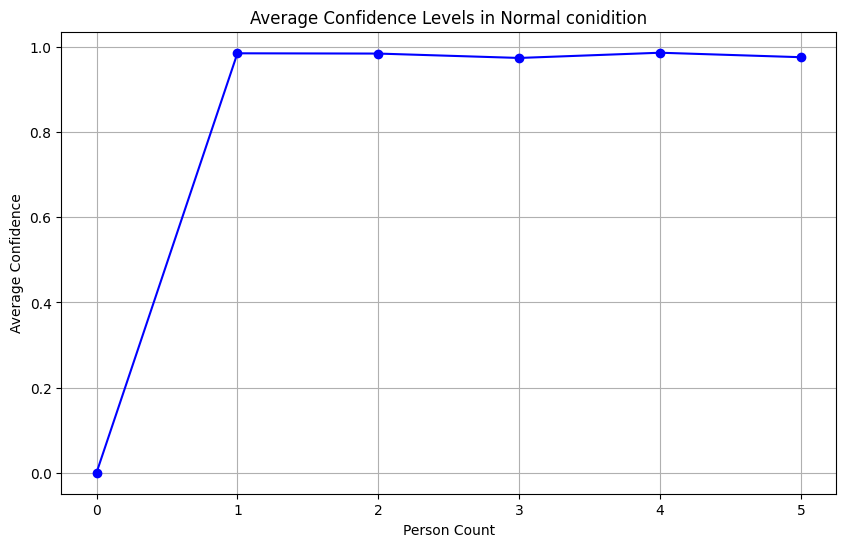

In [ ]:
average_confidences = []

for i in range(6):
    average_confidence = normal_dfs[i]['Average Confidence'].mean()
    average_confidences.append(average_confidence)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(6), average_confidences, marker='o', linestyle='-', color='b')
plt.title('Average Confidence Levels in Normal conidition')
plt.xlabel('Person Count')
plt.ylabel('Average Confidence')
plt.xticks(range(6))
plt.grid(True)
plt.show()

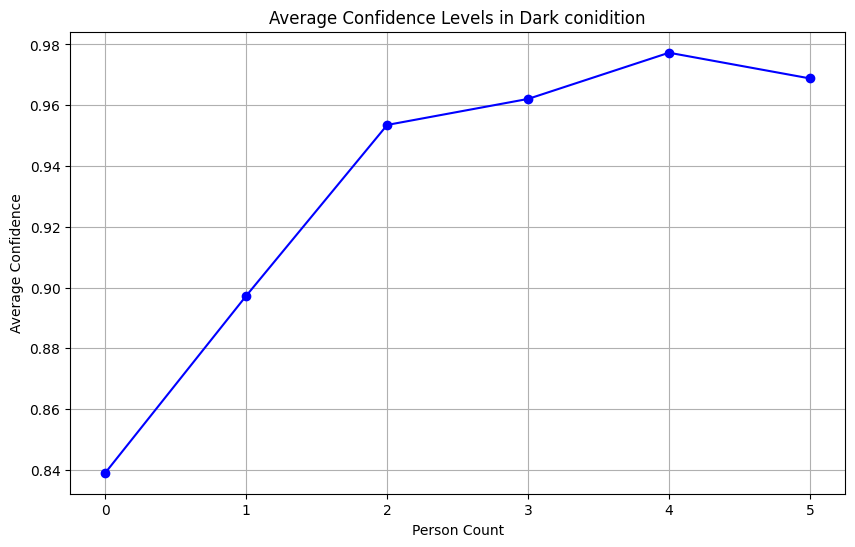

In [ ]:
average_confidences = []

for i in range(6):
    average_confidence = dark_dfs[i]['Average Confidence'].mean()
    average_confidences.append(average_confidence)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(6), average_confidences, marker='o', linestyle='-', color='b')
plt.title('Average Confidence Levels in Dark conidition')
plt.xlabel('Person Count')
plt.ylabel('Average Confidence')
plt.xticks(range(6))
plt.grid(True)
plt.show()

## Combine output

In [ ]:
for i in range(6):
  predictions = prediction_list[i][:len(normal_dfs[i])]
  normal_dfs[i]['csi_prediction'] = predictions

In [ ]:
for i in range(6):
  predictions = prediction_list[i][:len(dark_dfs[i])]
  dark_dfs[i]['csi_prediction'] = predictions

In [ ]:
cv_weight = 0.6
csi_weight = 0.4
for i in range(6):
  cv_output = normal_dfs[i]['Persons']     # Prediction from CV model
  csi_output = normal_dfs[i]['csi_prediction']      # Prediction from CSI model
  # Weighted average for final count
  normal_dfs[i]['combined_output'] = (cv_weight * cv_output + csi_weight * csi_output) / (cv_weight + csi_weight)

In [ ]:
cv_weight = 0.3
csi_weight = 0.7
for i in range(6):
  cv_output = dark_dfs[i]['Persons']     # Prediction from CV model
  csi_output = dark_dfs[i]['csi_prediction']      # Prediction from CSI model
  # Weighted average for final count
  dark_dfs[i]['combined_output'] = (cv_weight * cv_output + csi_weight * csi_output) / (cv_weight + csi_weight)

In [ ]:
print(normal_dfs[0])

                           Image  Persons  Average Confidence  csi_prediction  \
0    frame_1728097998.855235.jpg        0                 0.0        0.015930   
1   frame_1728098000.9172633.jpg        0                 0.0        0.038189   
2   frame_1728098002.9793704.jpg        0                 0.0       -0.024844   
3    frame_1728098005.035101.jpg        0                 0.0       -0.005996   
4   frame_1728098007.0977054.jpg        0                 0.0        0.134820   
..                           ...      ...                 ...             ...   
82  frame_1728098166.7888803.jpg        0                 0.0        0.079353   
83  frame_1728098168.8334026.jpg        0                 0.0        0.074596   
84  frame_1728098170.8800275.jpg        0                 0.0        0.086957   
85  frame_1728098172.9336915.jpg        0                 0.0        0.043418   
86  frame_1728098175.0015726.jpg        0                 0.0        0.037239   

    combined_output  
0    

In [ ]:
print(dark_dfs[0])

                           Image  Persons  Average Confidence  csi_prediction  \
0    frame_1728097998.855235.jpg        1                0.97        0.015930   
1   frame_1728098000.9172633.jpg        1                0.89        0.038189   
2   frame_1728098002.9793704.jpg        1                0.99       -0.024844   
3    frame_1728098005.035101.jpg        1                0.63       -0.005996   
4   frame_1728098007.0977054.jpg        1                0.98        0.134820   
..                           ...      ...                 ...             ...   
82  frame_1728098166.7888803.jpg        1                0.82        0.079353   
83  frame_1728098168.8334026.jpg        2                0.79        0.074596   
84  frame_1728098170.8800275.jpg        2                0.63        0.086957   
85  frame_1728098172.9336915.jpg        2                0.65        0.043418   
86  frame_1728098175.0015726.jpg        2                0.89        0.037239   

    combined_output  
0    

In [ ]:
from sklearn.metrics import median_absolute_error

for i in range(6):
    target_value = i
    target_array = np.full_like(normal_dfs[i]['combined_output'], target_value)
    med_ae = median_absolute_error(target_array, normal_dfs[i]['combined_output'])
    print(f'Median Absolute Error (MedAE) of {i} person count: {med_ae}')

Median Absolute Error (MedAE) of 0 person count: 0.02671736478805542
Median Absolute Error (MedAE) of 1 person count: 0.025675043463707026
Median Absolute Error (MedAE) of 2 person count: 0.06927375793457036
Median Absolute Error (MedAE) of 3 person count: 0.21985849738121033
Median Absolute Error (MedAE) of 4 person count: 0.15911409854888925
Median Absolute Error (MedAE) of 5 person count: 0.70615199804306


In [ ]:
from sklearn.metrics import median_absolute_error

for i in range(6):
    target_value = i
    target_array = np.full_like(dark_dfs[i]['combined_output'], target_value)
    med_ae = median_absolute_error(target_array, dark_dfs[i]['combined_output'])
    print(f'Median Absolute Error (MedAE) of {i} person count: {med_ae}')

Median Absolute Error (MedAE) of 0 person count: 0.352093543112278
Median Absolute Error (MedAE) of 1 person count: 0.2925828754901887
Median Absolute Error (MedAE) of 2 person count: 0.12122907638549796
Median Absolute Error (MedAE) of 3 person count: 0.24160888195037833
Median Absolute Error (MedAE) of 4 person count: 0.17560224533081037
Median Absolute Error (MedAE) of 5 person count: 0.4780432462692259


In [ ]:
print("YOLO Predictions in dark conditions")
for i in range(6):
    print(i, "person")
    total_predictions = dark_dfs[i].shape[0]
    print("Total predictions:", total_predictions)
    wrong_count = dark_dfs[i][round(dark_dfs[i]['combined_output']) != i].shape[0]
    print("Number of wrong predictions:", wrong_count)
    print("======================================")

YOLO Predictions in dark conditions
0 person
Total predictions: 87
Number of wrong predictions: 11
1 person
Total predictions: 86
Number of wrong predictions: 13
2 person
Total predictions: 85
Number of wrong predictions: 10
3 person
Total predictions: 86
Number of wrong predictions: 10
4 person
Total predictions: 85
Number of wrong predictions: 11
5 person
Total predictions: 86
Number of wrong predictions: 40
